# Fit MRP parameters to data in the form a traditional mass function curve

In this example, we do something very simple -- fit the MRP parameters using a theoretically produced HMF. This might be one of the first things you'd want to do with the MRP. In addition to the simple fit, we'll also change the truncation scale, to see how the fit performs over different mass ranges. Furthermore, we'll change the redshift and halo overdensity to make sure the fit performs well in all cases.

**The resulting plot appears as figure 1 in Murray, Robotham, Power (2017)**

In [2]:
#Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from mrpy.fitting.fit_curve import get_fit_curve

from os.path import join, expanduser

#We'll use the hmf package to produce the theoretical HMF
from hmf import MassFunction
from hmf.cosmo import Planck13

In [17]:
fig_folder = expanduser("~/Documents/Projects/MRP/mrpArticle/figures/")

First, we produce a *hmf* model consistent with the Planck 2013 data, and resolved enough to produce a high-quality fit:

In [3]:
hmf = MassFunction(hmf_model="Tinker08",Mmin=5,Mmax=18,lnk_min=-13,lnk_max=13,
                   transfer_model="CAMB",
                   dlnk=0.01,
                   sigma_8=0.829,n=0.9603,dlog10m=0.1,cosmo_model=Planck13)

Here's the important part: actually fitting the data.

## Fit across redshift and overdensity

In [13]:
# Create the lists that we'll use to save the results
res = [0]*64
obj = [0]*64
max_dev = np.zeros(64)
rms_dev = np.zeros(64)
dndms_whole = [0]*64
ms_whole = [0]*64

# 4 different truncation masses
sigmins = [4,3,2,1.5]
mmins = [1e10,1e11,1e12,1e13]
deltahs = [200.0,400.0,800.0,1600.0]
zs = [0.0,0.5,1.0,2.0]

dndms = [0]*64
ii = 0
for i,z in enumerate(zs):
    for j,deltah in enumerate(deltahs):
        hmf.update(z=z,delta_h=deltah)
        
        for k,sigmin in enumerate(sigmins): 
            # Get theoretical data
            mask = np.logical_and(hmf.sigma < sigmin, hmf.sigma > 0.5)
            dn = hmf.dndm[mask]
            m = hmf.m[mask]

            # Fit the MRP in the *simplest* way possible.
            res[ii], obj[ii] = get_fit_curve(m, dn, 
                                             x0 = [14.4,-1.9,0.8,-43],
                                             bounds=[[None,None],[-2.5,-1.5],[0.2,None],[None,None]], 
                                             jac=False)
            
            max_dev[ii] = np.abs(obj[ii].dndm()/dn-1).max()
            rms_dev[ii] = np.sqrt(np.mean((obj[ii].dndm()/dn-1)**2))
            dndms[ii] = dn
            dndms_whole[ii] = hmf.dndm
            ms_whole[ii] = hmf.m
            
            #print z, deltah, "%1.0e : "%mmin, res[ii].x, max_dev[ii], rms_dev[ii] # the actual result values
            ii += 1

Next the boring stuff... setting up and plotting the figure.

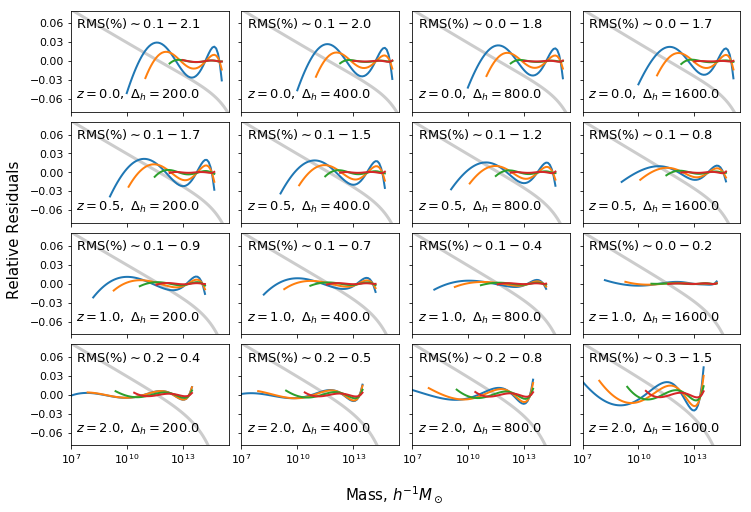

In [18]:
# Create the figure object
xmin_plot = 1e7
xmax_plot = 3e15
ymin_plot = -0.08
ymax_plot = 0.08
fig,ax = plt.subplots(4,4,sharex=True,sharey=True,squeeze=True,figsize=(12,8),
                      subplot_kw={"xscale":"log","ylim":(ymin_plot,ymax_plot),
                                  "xlim":(xmin_plot, xmax_plot)})

# Contract the space a bit
plt.subplots_adjust(wspace=0.08,hspace=0.10)
    
# Plot the fitted data.
# Note that 'obj' contains lots of quantities of interest, not least of which is a method
# to calculate dn/dm!
ii = 0
for i,z in enumerate(zs):
    for j,deltah in enumerate(deltahs):
        ax[i,j].text(2*xmin_plot,0.053, "RMS(%)" + r"$\sim %1.1f - %1.1f$"%(rms_dev[ii:ii+4].min()*100,rms_dev[ii:ii+4].max()*100),fontsize=13)
        ax[i,j].text(2*xmin_plot,-0.06,r"$z=%s,\ \Delta_h=%s$"%(z,deltah),fontsize=13)
        
        for k,mmin in enumerate(mmins):
            # Background grey scaled MF
            if k==0:
                mask = np.logical_and(ms_whole[ii]>xmin_plot, ms_whole[ii]<xmax_plot)
                dndm = np.log10(dndms_whole[ii][mask])
                if ii==0:
                    dndm_range = np.max(dndm) - np.min(dndm)
                dndm *= (ymax_plot - ymin_plot)/dndm_range
                dndm += ymax_plot - np.max(dndm)
                ax[i,j].plot(ms_whole[ii][mask], dndm, color='grey', alpha=0.4,lw=3)
            
            # Plot each iteration
            ax[i,j].plot(obj[ii].m,obj[ii].dndm()/dndms[ii]-1,lw=2)
            # Modify the ticks for prettiness
            ax[i,j].tick_params(axis='both', which='major', labelsize=11)
            ax[i,j].tick_params(axis='both', which='major', labelsize=11)
            ax[i,j].yaxis.set_major_locator(MaxNLocator(6))
            
            
            
            ii += 1
       
fig.text(0.5, 0.04, r"Mass, $h^{-1}M_\odot$",fontsize=15, ha='center', va='center')
fig.text(0.06, 0.5, 'Relative Residuals', fontsize=15,ha='center', va='center', rotation='vertical')

#Save image
if fig_folder:
    fig.savefig(join(fig_folder,"comparison_tinker.pdf"))

## Fit against different cosmology and halo type

In [22]:
hmf = MassFunction(hmf_model="Warren",Mmin=5,Mmax=18,lnk_min=-13,lnk_max=13,
                   transfer_model="CAMB",
                   dlnk=0.01,
                   sigma_8=0.829,n=0.9603,dlog10m=0.1,cosmo_model=Planck13)

In [23]:
# Create the lists that we'll use to save the results
res = [0]*64
obj = [0]*64
max_dev = np.zeros(64)
rms_dev = np.zeros(64)
# 4 different truncation masses
sigmins = [4,3,2,1.5]
oms = [0.2, 0.25, 0.3, 0.35]
s8s = [0.7, 0.8, 0.9, 1.0]

dndms = [0]*64
ii = 0
for i,s8 in enumerate(s8s):
    for j,om in enumerate(oms):
        hmf.update(cosmo_params={"Om0":om}, sigma_8 = s8)
        
        for k,sigmin in enumerate(sigmins): 

        
            # Get theoretical data
            mask = np.logical_and(hmf.sigma < sigmin, hmf.sigma > 0.5)
            dn = hmf.dndm[mask]
            m = hmf.m[mask]

            # Fit the MRP in the *simplest* way possible.
            res[ii], obj[ii] = get_fit_curve(m, dn, 
                                             x0 = [14.4,-1.9,0.8,-43],
                                             bounds=[[None,None],[-2.5,-1.5],[0.2,None],[None,None]], 
                                             jac=False)
            
            max_dev[ii] = np.abs(obj[ii].dndm()/dn-1).max()
            rms_dev[ii] = np.sqrt(np.mean((obj[ii].dndm()/dn-1)**2))
            dndms[ii] = dn
                        
            dndms_whole[ii] = hmf.dndm
            ms_whole[ii] = hmf.m
            
            #print z, deltah, "%1.0e : "%mmin, res[ii].x, max_dev[ii], rms_dev[ii] # the actual result values
            ii += 1

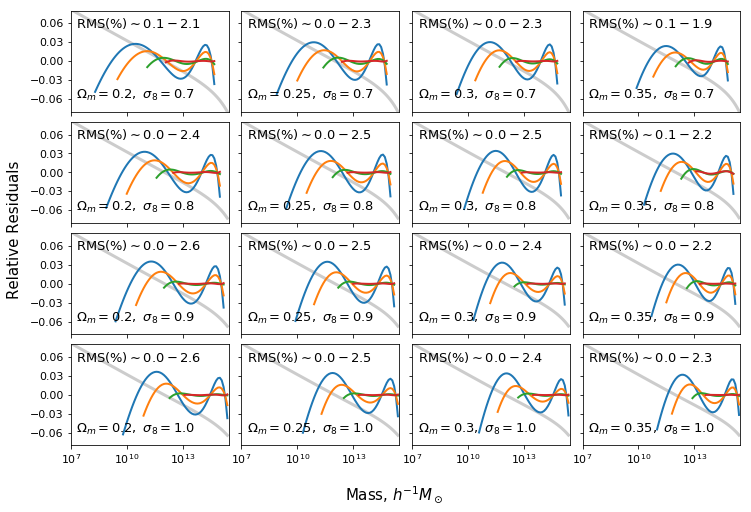

In [25]:
xmin_plot = 1e7
xmax_plot = 3e15
ymin_plot = -0.08
ymax_plot = 0.08
fig,ax = plt.subplots(4,4,sharex=True,sharey=True,squeeze=True,figsize=(12,8),
                      subplot_kw={"xscale":"log","ylim":(ymin_plot,ymax_plot),
                                  "xlim":(xmin_plot, xmax_plot)})
# Contract the space a bit
plt.subplots_adjust(wspace=0.08,hspace=0.10)
    
# Plot the fitted data.
# Note that 'obj' contains lots of quantities of interest, not least of which is a method
# to calculate dn/dm!
ii = 0
for i,s8 in enumerate(s8s):
    for j,om in enumerate(oms):
        ax[i,j].text(2*xmin_plot,0.053, "RMS(%)" + r"$\sim %1.1f - %1.1f$"%(rms_dev[ii:ii+4].min()*100,rms_dev[ii:ii+4].max()*100),fontsize=13)
        ax[i,j].text(2*xmin_plot,-0.06,r"$\Omega_m=%s,\ \sigma_8=%s$"%(om,s8),fontsize=13)
        
        for k,mmin in enumerate(mmins):
            if k==0:
                mask = np.logical_and(ms_whole[ii]>xmin_plot, ms_whole[ii]<xmax_plot)
                dndm = np.log10(dndms_whole[ii][mask])
                if ii==0:
                    dndm_range = np.max(dndm) - np.min(dndm)
                dndm *= (ymax_plot - ymin_plot)/dndm_range
                dndm += ymax_plot - np.max(dndm)
                ax[i,j].plot(ms_whole[ii][mask], dndm, color='grey', alpha=0.4,lw=3)
                
            # Plot each iteration
            ax[i,j].plot(obj[ii].m,obj[ii].dndm()/dndms[ii]-1,lw=2)
            
            # Modify the ticks for prettiness
            ax[i,j].tick_params(axis='both', which='major', labelsize=11)
            ax[i,j].tick_params(axis='both', which='major', labelsize=11)
            ax[i,j].yaxis.set_major_locator(MaxNLocator(6))
            
            
            
            ii += 1
       
fig.text(0.5, 0.04, r"Mass, $h^{-1}M_\odot$",fontsize=15, ha='center', va='center')
fig.text(0.06, 0.5, 'Relative Residuals', fontsize=15,ha='center', va='center', rotation='vertical')

#Save image
if fig_folder:
    fig.savefig(join(fig_folder,"comparison_warren.pdf"))